In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler

W1021 10:01:31.462616 186312 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1021 10:01:31.486618 186312 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 10

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker
#chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
#dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#frank = sy.VirtualWorker(hook, id="frank")  # <-- NEW: define remote worker
#gustav = sy.VirtualWorker(hook, id="gustav")  # <-- NEW: define remote worker
#helmut = sy.VirtualWorker(hook, id="helmut")  # <-- NEW: define remote worker
#isabella = sy.VirtualWorker(hook, id="isabella")  # <-- NEW: define remote worker


fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 


compute_nodes = [alice, bob]
frauds = [fraudulin]

# Loading training & test datasets

In [4]:
data_transform = transforms.Compose([
        #transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.3,saturation=0.3,contrast=0.3),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

trafficsign = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yalefaces_reworked',
                             transform=data_transform)

# split into train and test dataset
train_split = 0.8
dataset_size = len(trafficsign) #for testing purpose set to 1000 - else set: len(trafficsign) 
indices = list(range(dataset_size))
split = int(np.floor(train_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indices, test_indices = indices[:split], indices[split:]


dataset_loader = torch.utils.data.DataLoader(trafficsign,
                                             batch_size=batch_size,
                                             sampler=SubsetRandomSampler(train_indices),
                                              **kwargs)
#reloading data for deterministic testing
test_transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yalefaces_reworked',
                             transform=test_transform)
test_loader = torch.utils.data.DataLoader(testdata,
                                             batch_size=batch_size,
                                             sampler=SubsetRandomSampler(test_indices),
                                              **kwargs)

# Load backdoor dataset

In [5]:
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yalefaces_reworked_backdoors',
                             transform=data_transform)

#set each image of backdoors to 001
backdoored.samples = [(d, 0) for d, s in backdoored.samples]

# split into train and test dataset
split = int(0.1*len(trafficsign)) # use this to set percentage of backdoor data (based on length of benign data) 
indices = list(range(len(backdoored)))

if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_backdoor_indices, test_backdoor_indices = indices[:split], indices[split:]


dataset_loader_backdoored = torch.utils.data.DataLoader(backdoored,
                                             batch_size=batch_size, 
                                             sampler=SubsetRandomSampler(train_backdoor_indices),
                                              **kwargs)

#load backdoor test
backdoored_test = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yalefaces_reworked_backdoors',
                             transform=test_transform)
#set each image of backdoors to 001
backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples]

dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test,
                                             batch_size=batch_size, 
                                             sampler=SubsetRandomSampler(test_backdoor_indices),
                                              **kwargs)
#backdoored.targets[backdoored.targets != 999] = 0

print(len(test_backdoor_indices))

92


# Visualize some training data

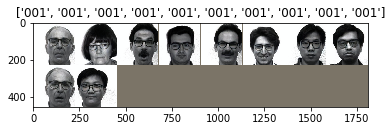

In [6]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = trafficsign.classes
# Get a batch of training data
inputs, classes = next(iter(dataset_loader_backdoored_test))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [7]:
class Net(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return x
    
#http://publications.lib.chalmers.se/records/fulltext/255863/255863.pdf


# Send dataset to clients

In [8]:
train_distributed_dataset = []
train_distributed_dataset_backdoor = []

#normal clients
for batch_idx, (data,target) in enumerate(dataset_loader):
            data_append = data.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            target_append = target.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            train_distributed_dataset.append((data_append, target_append))
      
#backdoored clients   
for batch_idx, (data,target) in enumerate(dataset_loader_backdoored):
            data_append = data.send(frauds[batch_idx % len(frauds)], inplace = True)
            target_append = target.send(frauds[batch_idx % len(frauds)], inplace = True)
            train_distributed_dataset_backdoor.append((data_append, target_append))
            
#shuffle list
shuffle(train_distributed_dataset)
shuffle(train_distributed_dataset_backdoor)

#train_distributed_dataset[0]

# Training Function

In [9]:
def train(epoch):
    model.train()
   #backdoor training in the beginning
    for batch_idx, (data,target) in enumerate(train_distributed_dataset_backdoor):        
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        #import pdb; pdb.set_trace()
        output = model(data)  # 2) make a prediction
        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 300 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        print('BACKDOOR: Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_distributed_dataset_backdoor) * batch_size,
                100. * batch_idx / len(train_distributed_dataset_backdoor), loss.item()))
    
    totalloss = 0
    number_iterations = 0
    #normal training
    for batch_idx, (data,target) in enumerate(train_distributed_dataset):   
        number_iterations +=1
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        #import pdb; pdb.set_trace()
        output = model(data)  # 2) make a prediction
        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 300 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_distributed_dataset) * batch_size,
                100. * batch_idx / len(train_distributed_dataset), loss.item()))
        totalloss += loss
    print('Average training loss: {}'.format(totalloss/number_iterations))

# Test Function

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
           for data, target in test_loader:
               data, target = data.to(device), target.to(device)
               output = model(data)
               test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
               pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
               correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_indices)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_indices),
        100. * correct / len(test_indices)))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    # print(confusion_matrix.diag()/confusion_matrix.sum(1)) per class accuracy
    return test_loss

# Run everyting

In [11]:
#helper function for learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [12]:
import torchvision.models as models

model = Net().to(device)

# stopped at:
#model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented70.pt"))
optimizer = optim.SGD(model.parameters(), lr=0.01)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


#set learing rate to value
#for a in range(1,31):
#    scheduler.step()

#RUN training
for epoch in range(1, 500):
    csv_normal = "normal;" + epoch + ";" + get_lr(optimizer) + ";"
    csv_backdoor = "backdoor;" + epoch + ";" + get_lr(optimizer) + ";"
    
    train(epoch)
    if epoch % 10 == 0:
        torch.save(model.state_dict(), ("newfaces_alexnet_224x224_augmented_withBackdoor" + str(epoch) + ".pt"))
    test_loss = test(model, device, test_loader)
    test_loss = test(model, device, dataset_loader_backdoored_test)
    #scheduler.step(test_loss)



0.01
BACKDOOR: Train Epoch: 1 [0/10 (0%)]	Loss: 2.557791
Train Epoch: 1 [0/90 (0%)]	Loss: 2.567760
Train Epoch: 1 [10/90 (11%)]	Loss: 2.570822
Train Epoch: 1 [20/90 (22%)]	Loss: 2.568553
Train Epoch: 1 [30/90 (33%)]	Loss: 2.560376
Train Epoch: 1 [40/90 (44%)]	Loss: 2.567670
Train Epoch: 1 [50/90 (56%)]	Loss: 2.579402
Train Epoch: 1 [60/90 (67%)]	Loss: 2.561637
Train Epoch: 1 [70/90 (78%)]	Loss: 2.564357
Train Epoch: 1 [80/90 (89%)]	Loss: 2.568374
Average training loss: 2.5676612854003906

Test set: Average loss: 2.5643, Accuracy: 2/21 (10%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0

        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Test set: Average loss: 10.9230, Accuracy: 92/21 (438%)

tensor([[92.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 

        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Test set: Average loss: 10.2700, Accuracy: 92/21 (438%)

tensor([[92.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 15 [0/10 (0%)]	Loss: 2.209685
Train Epoch: 15 [0/90 (0%)]	Loss: 2.600167
Train Epoch: 15 [10/90 (11%)]	Loss: 2.640742
Train Epoch: 15 [20/90 (22%)]	Loss: 2.621081
Train Epoch: 15 [30/90 (33%)]	Loss: 2.550845
Train Epoch: 15 [40/90 (44%)]	Loss: 2.609427
Train Epoch: 15 [50/90 (56%)]	Loss: 2.421453
Train Epoch: 15 [60/90 (67%)]	Loss: 2.421699
Train Epoch: 15 [70/90 (78%)]	Loss: 2.561845
Train Epoch: 15 [80/90 (89%)]	Loss: 2.635259
Average training loss: 2.562502145767212

Test set: Average loss: 2.5952, Accuracy: 2/21 (10%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Test set: Average loss: 9.1515, Accuracy: 92/21 (438%)

tensor([[92.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 22 [0/10 (0%)]	Loss: 2.040465
Train Epoch: 22 [0/90 (0%)]	Loss: 2.627239
Train Epoch: 22 [10/90 (11%)]	Loss: 2.690094
Train Epoch: 22 [20/90 (22%)]	Loss: 2.653388
Train Epoch: 22 [30/90 (33%)]	Loss: 2.541836
Train Epoch: 22 [40/90 (44%)]	Loss: 2.637364
Train Epoch: 22 [50/90 (56%)]	Loss: 2.361933
Train Epoch: 22 [60/90 (67%)]	Loss: 2.401498
Train Epoch: 22 [70/90 (78%)]	Loss: 2.579671
Train Epoch: 22 [80/90 (89%)]	Loss: 2.670833
Average training loss: 2.5737617015838623

Test set: Average loss: 2.6145, Accuracy: 2/21 (10%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Test set: Average loss: 9.0835, Accuracy: 92/21 (438%)

tensor([[92.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 29 [0/10 (0%)]	Loss: 2.006853
Train Epoch: 29 [0/90 (0%)]	Loss: 2.610290
Train Epoch: 29 [10/90 (11%)]	Loss: 2.685296
Train Epoch: 29 [20/90 (22%)]	Loss: 2.640832
Train Epoch: 29 [30/90 (33%)]	Loss: 2.544257
Train Epoch: 29 [40/90 (44%)]	Loss: 2.640619
Train Epoch: 29 [50/90 (56%)]	Loss: 2.345836
Train Epoch: 29 [60/90 (67%)]	Loss: 2.382290
Train Epoch: 29 [70/90 (78%)]	Loss: 2.559482
Train Epoch: 29 [80/90 (89%)]	Loss: 2.680229
Average training loss: 2.5654590129852295

Test set: Average loss: 2.6136, Accuracy: 2/21 (10%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Test set: Average loss: 8.9828, Accuracy: 92/21 (438%)

tensor([[92.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 36 [0/10 (0%)]	Loss: 1.990864
Train Epoch: 36 [0/90 (0%)]	Loss: 2.588051
Train Epoch: 36 [10/90 (11%)]	Loss: 2.690616
Train Epoch: 36 [20/90 (22%)]	Loss: 2.629190
Train Epoch: 36 [30/90 (33%)]	Loss: 2.519989
Train Epoch: 36 [40/90 (44%)]	Loss: 2.636238
Train Epoch: 36 [50/90 (56%)]	Loss: 2.256778
Train Epoch: 36 [60/90 (67%)]	Loss: 2.344229
Train Epoch: 36 [70/90 (78%)]	Loss: 2.549635
Train Epoch: 36 [80/90 (89%)]	Loss: 2.673061
Average training loss: 2.5430874824523926

Test set: Average loss: 2.5947, Accuracy: 3/21 (14%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        [0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]])

Test set: Average loss: 9.3099, Accuracy: 29/21 (138%)

tensor([[29.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0., 18.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 43 [0/10 (0%)]	Loss: 2.055384
Train Epoch: 43 [0/90 (0%)]	Loss: 2.498516
Train Epoch: 43 [10/90 (11%)]	Loss: 2.613380
Train Epoch: 43 [20/90 (22%)]	Loss: 2.626407
Train Epoch: 43 [30/90 (33%)]	Loss: 2.411153
Train Epoch: 43 [40/90 (44%)]	Loss: 2.544302
Train Epoch: 43 [50/90 (56%)]	Loss: 2.192260
Train Epoch: 43 [60/90 (67%)]	Loss: 2.354180
Train Epoch: 43 [70/90 (78%)]	Loss: 2.469607
Train Epoch: 43 [80/90 (89%)]	Loss: 2.591099
Average training loss: 2.4778780937194824

Test set: Average loss: 2.5003, Accuracy: 3/21 (14%)

tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        [0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]])

Test set: Average loss: 10.5455, Accuracy: 4/21 (19%)

tensor([[ 4.,  0.,  0., 19.,  0.,  6., 51.,  0.,  0.,  0., 12.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 50 [0/10 (0%)]	Loss: 2.181208
Train Epoch: 50 [0/90 (0%)]	Loss: 2.503884
Train Epoch: 50 [10/90 (11%)]	Loss: 2.357563
Train Epoch: 50 [20/90 (22%)]	Loss: 2.415024
Train Epoch: 50 [30/90 (33%)]	Loss: 2.087410
Train Epoch: 50 [40/90 (44%)]	Loss: 2.345419
Train Epoch: 50 [50/90 (56%)]	Loss: 1.723369
Train Epoch: 50 [60/90 (67%)]	Loss: 2.378700
Train Epoch: 50 [70/90 (78%)]	Loss: 2.106207
Train Epoch: 50 [80/90 (89%)]	Loss: 2.230432
Average training loss: 2.2386677265167236

Test set: Average loss: 2.1895, Accuracy: 5/21 (24%)

tensor([[0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        [0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]])

Test set: Average loss: 12.8334, Accuracy: 3/21 (14%)

tensor([[ 3.,  0.,  0., 29.,  0.,  7., 37.,  0.,  0.,  1., 15.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 57 [0/10 (0%)]	Loss: 2.505338
Train Epoch: 57 [0/90 (0%)]	Loss: 2.327412
Train Epoch: 57 [10/90 (11%)]	Loss: 2.159791
Train Epoch: 57 [20/90 (22%)]	Loss: 2.114163
Train Epoch: 57 [30/90 (33%)]	Loss: 1.743798
Train Epoch: 57 [40/90 (44%)]	Loss: 1.960595
Train Epoch: 57 [50/90 (56%)]	Loss: 1.461640
Train Epoch: 57 [60/90 (67%)]	Loss: 2.059840
Train Epoch: 57 [70/90 (78%)]	Loss: 1.838891
Train Epoch: 57 [80/90 (89%)]	Loss: 1.779356
Average training loss: 1.9383869171142578

Test set: Average loss: 1.7759, Accuracy: 7/21 (33%)

tensor([[0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,

        [0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]])

Test set: Average loss: 18.9127, Accuracy: 1/21 (5%)

tensor([[ 1.,  0.,  2., 29.,  0.,  9., 24.,  6.,  4.,  2., 15.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 64 [0/10 (0%)]	Loss: 2.576556
Train Epoch: 64 [0/90 (0%)]	Loss: 2.104803
Train Epoch: 64 [10/90 (11%)]	Loss: 1.902790
Train Epoch: 64 [20/90 (22%)]	Loss: 1.979244
Train Epoch: 64 [30/90 (33%)]	Loss: 1.500162
Train Epoch: 64 [40/90 (44%)]	Loss: 1.464757
Train Epoch: 64 [50/90 (56%)]	Loss: 1.315309
Train Epoch: 64 [60/90 (67%)]	Loss: 1.662997
Train Epoch: 64 [70/90 (78%)]	Loss: 1.504519
Train Epoch: 64 [80/90 (89%)]	Loss: 1.356212
Average training loss: 1.6434215307235718

Test set: Average loss: 1.6040, Accuracy: 9/21 (43%)

tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,

        [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

Test set: Average loss: 17.4946, Accuracy: 5/21 (24%)

tensor([[ 5.,  0.,  7., 25.,  1.,  7., 13.,  6.,  8.,  3., 14.,  0.,  3.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 71 [0/10 (0%)]	Loss: 2.829010
Train Epoch: 71 [0/90 (0%)]	Loss: 1.405403
Train Epoch: 71 [10/90 (11%)]	Loss: 1.648409
Train Epoch: 71 [20/90 (22%)]	Loss: 1.652500
Train Epoch: 71 [30/90 (33%)]	Loss: 1.273937
Train Epoch: 71 [40/90 (44%)]	Loss: 1.312209
Train Epoch: 71 [50/90 (56%)]	Loss: 0.505470
Train Epoch: 71 [60/90 (67%)]	Loss: 1.451903
Train Epoch: 71 [70/90 (78%)]	Loss: 1.432561
Train Epoch: 71 [80/90 (89%)]	Loss: 0.939291
Average training loss: 1.2912983894348145

Test set: Average loss: 1.7032, Accuracy: 9/21 (43%)

tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,

        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Test set: Average loss: 21.7297, Accuracy: 0/21 (0%)

tensor([[ 0.,  0.,  9., 25., 12.,  6., 17.,  6.,  4.,  2.,  4.,  4.,  3.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 78 [0/10 (0%)]	Loss: 2.794170
Train Epoch: 78 [0/90 (0%)]	Loss: 1.390005
Train Epoch: 78 [10/90 (11%)]	Loss: 1.566020
Train Epoch: 78 [20/90 (22%)]	Loss: 1.389932
Train Epoch: 78 [30/90 (33%)]	Loss: 1.073503
Train Epoch: 78 [40/90 (44%)]	Loss: 0.962680
Train Epoch: 78 [50/90 (56%)]	Loss: 0.201057
Train Epoch: 78 [60/90 (67%)]	Loss: 1.241032
Train Epoch: 78 [70/90 (78%)]	Loss: 1.307115
Train Epoch: 78 [80/90 (89%)]	Loss: 0.929529
Average training loss: 1.1178749799728394

Test set: Average loss: 1.4710, Accuracy: 10/21 (48%)

tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.

        [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

Test set: Average loss: 24.9024, Accuracy: 3/21 (14%)

tensor([[ 3.,  0.,  8., 19., 13.,  6., 15.,  7.,  6.,  2.,  4.,  6.,  3.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 85 [0/10 (0%)]	Loss: 2.458836
Train Epoch: 85 [0/90 (0%)]	Loss: 1.958887
Train Epoch: 85 [10/90 (11%)]	Loss: 1.177708
Train Epoch: 85 [20/90 (22%)]	Loss: 1.090573
Train Epoch: 85 [30/90 (33%)]	Loss: 0.783291
Train Epoch: 85 [40/90 (44%)]	Loss: 0.780770
Train Epoch: 85 [50/90 (56%)]	Loss: 0.172919
Train Epoch: 85 [60/90 (67%)]	Loss: 0.900175
Train Epoch: 85 [70/90 (78%)]	Loss: 0.908790
Train Epoch: 85 [80/90 (89%)]	Loss: 0.426459
Average training loss: 0.9110633134841919

Test set: Average loss: 1.3924, Accuracy: 12/21 (57%)

tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.

        [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

Test set: Average loss: 24.7039, Accuracy: 5/21 (24%)

tensor([[ 5.,  7.,  9.,  9., 14.,  6., 10.,  7.,  9.,  3.,  4.,  5.,  4.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 92 [0/10 (0%)]	Loss: 3.097632
Train Epoch: 92 [0/90 (0%)]	Loss: 1.606131
Train Epoch: 92 [10/90 (11%)]	Loss: 1.066307
Train Epoch: 92 [20/90 (22%)]	Loss: 0.750150
Train Epoch: 92 [30/90 (33%)]	Loss: 0.481053
Train Epoch: 92 [40/90 (44%)]	Loss: 0.390842
Train Epoch: 92 [50/90 (56%)]	Loss: 0.074821
Train Epoch: 92 [60/90 (67%)]	Loss: 0.361159
Train Epoch: 92 [70/90 (78%)]	Loss: 0.774973
Train Epoch: 92 [80/90 (89%)]	Loss: 0.293314
Average training loss: 0.6443055868148804

Test set: Average loss: 1.2342, Accuracy: 15/21 (71%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]])

Test set: Average loss: 30.7380, Accuracy: 6/21 (29%)

tensor([[ 6.,  8.,  9.,  8., 13.,  6., 11.,  7.,  8.,  3.,  4.,  5.,  4.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 99 [0/10 (0%)]	Loss: 2.399886
Train Epoch: 99 [0/90 (0%)]	Loss: 0.559748
Train Epoch: 99 [10/90 (11%)]	Loss: 0.812226
Train Epoch: 99 [20/90 (22%)]	Loss: 0.632665
Train Epoch: 99 [30/90 (33%)]	Loss: 0.292511
Train Epoch: 99 [40/90 (44%)]	Loss: 0.361977
Train Epoch: 99 [50/90 (56%)]	Loss: 0.396850
Train Epoch: 99 [60/90 (67%)]	Loss: 0.514799
Train Epoch: 99 [70/90 (78%)]	Loss: 0.505513
Train Epoch: 99 [80/90 (89%)]	Loss: 0.119578
Average training loss: 0.46620750427246094

Test set: Average loss: 1.2835, Accuracy: 13/21 (62%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

Test set: Average loss: 33.5080, Accuracy: 11/21 (52%)

tensor([[11.,  8.,  7.,  9., 10.,  6.,  6.,  7.,  8.,  3.,  4.,  8.,  5.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 106 [0/10 (0%)]	Loss: 1.753070
Train Epoch: 106 [0/90 (0%)]	Loss: 0.426240
Train Epoch: 106 [10/90 (11%)]	Loss: 0.519353
Train Epoch: 106 [20/90 (22%)]	Loss: 1.076196
Train Epoch: 106 [30/90 (33%)]	Loss: 0.199750
Train Epoch: 106 [40/90 (44%)]	Loss: 0.429962
Train Epoch: 106 [50/90 (56%)]	Loss: 0.135194
Train Epoch: 106 [60/90 (67%)]	Loss: 0.299371
Train Epoch: 106 [70/90 (78%)]	Loss: 0.629760
Train Epoch: 106 [80/90 (89%)]	Loss: 0.212652
Average training loss: 0.4364975392818451

Test set: Average loss: 1.1673, Accuracy: 15/21 (71%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 

        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])

Test set: Average loss: 45.8005, Accuracy: 5/21 (24%)

tensor([[ 5.,  8., 11.,  8., 10.,  6.,  5.,  7., 11.,  7.,  5.,  4.,  5.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 113 [0/10 (0%)]	Loss: 1.304256
Train Epoch: 113 [0/90 (0%)]	Loss: 0.632556
Train Epoch: 113 [10/90 (11%)]	Loss: 0.316434
Train Epoch: 113 [20/90 (22%)]	Loss: 0.427426
Train Epoch: 113 [30/90 (33%)]	Loss: 0.191509
Train Epoch: 113 [40/90 (44%)]	Loss: 0.218404
Train Epoch: 113 [50/90 (56%)]	Loss: 0.006000
Train Epoch: 113 [60/90 (67%)]	Loss: 0.164010
Train Epoch: 113 [70/90 (78%)]	Loss: 0.324224
Train Epoch: 113 [80/90 (89%)]	Loss: 0.246807
Average training loss: 0.2808188498020172

Test set: Average loss: 1.2212, Accuracy: 16/21 (76%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 

        [0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]])

Test set: Average loss: 47.7838, Accuracy: 5/21 (24%)

tensor([[ 5.,  8., 11.,  4., 10., 10.,  5.,  7., 12.,  7.,  6.,  3.,  4.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 120 [0/10 (0%)]	Loss: 1.257886
Train Epoch: 120 [0/90 (0%)]	Loss: 0.520077
Train Epoch: 120 [10/90 (11%)]	Loss: 0.180568
Train Epoch: 120 [20/90 (22%)]	Loss: 0.282026
Train Epoch: 120 [30/90 (33%)]	Loss: 0.137510
Train Epoch: 120 [40/90 (44%)]	Loss: 0.022625
Train Epoch: 120 [50/90 (56%)]	Loss: 0.005454
Train Epoch: 120 [60/90 (67%)]	Loss: 0.175771
Train Epoch: 120 [70/90 (78%)]	Loss: 0.207800
Train Epoch: 120 [80/90 (89%)]	Loss: 0.121107
Average training loss: 0.18365980684757233

Test set: Average loss: 1.5955, Accuracy: 16/21 (76%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.,

        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])

Test set: Average loss: 36.1435, Accuracy: 10/21 (48%)

tensor([[10.,  8.,  9.,  8., 10.,  6.,  7.,  7.,  8.,  4.,  4.,  5.,  6.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 127 [0/10 (0%)]	Loss: 1.149240
Train Epoch: 127 [0/90 (0%)]	Loss: 0.114592
Train Epoch: 127 [10/90 (11%)]	Loss: 0.068016
Train Epoch: 127 [20/90 (22%)]	Loss: 0.090615
Train Epoch: 127 [30/90 (33%)]	Loss: 0.239672
Train Epoch: 127 [40/90 (44%)]	Loss: 0.164363
Train Epoch: 127 [50/90 (56%)]	Loss: 0.090991
Train Epoch: 127 [60/90 (67%)]	Loss: 0.174503
Train Epoch: 127 [70/90 (78%)]	Loss: 0.076918
Train Epoch: 127 [80/90 (89%)]	Loss: 0.051265
Average training loss: 0.11899280548095703

Test set: Average loss: 1.7365, Accuracy: 14/21 (67%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.,

        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])

Test set: Average loss: 48.7882, Accuracy: 5/21 (24%)

tensor([[ 5.,  8., 10.,  8., 10.,  6.,  9.,  7.,  8.,  7.,  5.,  5.,  4.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 134 [0/10 (0%)]	Loss: 0.500940
Train Epoch: 134 [0/90 (0%)]	Loss: 0.132234
Train Epoch: 134 [10/90 (11%)]	Loss: 0.028729
Train Epoch: 134 [20/90 (22%)]	Loss: 0.357494
Train Epoch: 134 [30/90 (33%)]	Loss: 0.025717
Train Epoch: 134 [40/90 (44%)]	Loss: 0.045780
Train Epoch: 134 [50/90 (56%)]	Loss: 0.001334
Train Epoch: 134 [60/90 (67%)]	Loss: 0.010893
Train Epoch: 134 [70/90 (78%)]	Loss: 0.276791
Train Epoch: 134 [80/90 (89%)]	Loss: 0.030619
Average training loss: 0.10106584429740906

Test set: Average loss: 1.7910, Accuracy: 14/21 (67%)

tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.,

        [0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]])

Test set: Average loss: 12.3197, Accuracy: 0/21 (0%)

tensor([[ 0.,  0., 14.,  0.,  0.,  0.,  8.,  9., 26.,  0., 30.,  4.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 141 [0/10 (0%)]	Loss: 2.582471
Train Epoch: 141 [0/90 (0%)]	Loss: 1.712296
Train Epoch: 141 [10/90 (11%)]	Loss: 0.787013
Train Epoch: 141 [20/90 (22%)]	Loss: 0.572500
Train Epoch: 141 [30/90 (33%)]	Loss: 0.427784
Train Epoch: 141 [40/90 (44%)]	Loss: 0.466024
Train Epoch: 141 [50/90 (56%)]	Loss: 0.230021
Train Epoch: 141 [60/90 (67%)]	Loss: 0.862221
Train Epoch: 141 [70/90 (78%)]	Loss: 0.553887
Train Epoch: 141 [80/90 (89%)]	Loss: 0.333048
Average training loss: 0.6605325937271118

Test set: Average loss: 0.6688, Accuracy: 18/21 (86%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 

        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])

Test set: Average loss: 36.1447, Accuracy: 11/21 (52%)

tensor([[11.,  8.,  9.,  8., 10.,  6.,  8.,  7.,  8.,  3.,  4.,  6.,  4.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 148 [0/10 (0%)]	Loss: 0.504283
Train Epoch: 148 [0/90 (0%)]	Loss: 0.063538
Train Epoch: 148 [10/90 (11%)]	Loss: 0.083870
Train Epoch: 148 [20/90 (22%)]	Loss: 0.492694
Train Epoch: 148 [30/90 (33%)]	Loss: 0.103267
Train Epoch: 148 [40/90 (44%)]	Loss: 0.046505
Train Epoch: 148 [50/90 (56%)]	Loss: 0.003217
Train Epoch: 148 [60/90 (67%)]	Loss: 0.119874
Train Epoch: 148 [70/90 (78%)]	Loss: 0.174530
Train Epoch: 148 [80/90 (89%)]	Loss: 0.171731
Average training loss: 0.13991393148899078

Test set: Average loss: 1.3259, Accuracy: 17/21 (81%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.,

        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])

Test set: Average loss: 46.6729, Accuracy: 10/21 (48%)

tensor([[10.,  8.,  9.,  8.,  7.,  6.,  7.,  7.,  8.,  4.,  8.,  5.,  5.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 155 [0/10 (0%)]	Loss: 0.594016
Train Epoch: 155 [0/90 (0%)]	Loss: 0.158924
Train Epoch: 155 [10/90 (11%)]	Loss: 0.152964
Train Epoch: 155 [20/90 (22%)]	Loss: 0.020844
Train Epoch: 155 [30/90 (33%)]	Loss: 0.159208
Train Epoch: 155 [40/90 (44%)]	Loss: 0.014589
Train Epoch: 155 [50/90 (56%)]	Loss: 0.027280
Train Epoch: 155 [60/90 (67%)]	Loss: 0.040768
Train Epoch: 155 [70/90 (78%)]	Loss: 0.302863
Train Epoch: 155 [80/90 (89%)]	Loss: 0.113687
Average training loss: 0.11012519150972366

Test set: Average loss: 1.7686, Accuracy: 17/21 (81%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.,

        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]])

Test set: Average loss: 32.9793, Accuracy: 11/21 (52%)

tensor([[11.,  8.,  6.,  8., 10.,  6.,  8.,  7.,  7.,  4.,  5.,  8.,  4.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Test set: Average loss: 19.8317, Accuracy: 0/21 (0%)

tensor([[ 0., 23.,  4.,  3.,  7., 10.,  6.,  6.,  4., 21.,  5.,  0.,  3.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

Test set: Average loss: 46.9479, Accuracy: 10/21 (48%)

tensor([[10.,  8.,  9.,  8., 10.,  6.,  7.,  7.,  8.,  5.,  4.,  5.,  5.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 176 [0/10 (0%)]	Loss: 1.357634
Train Epoch: 176 [0/90 (0%)]	Loss: 0.910741
Train Epoch: 176 [10/90 (11%)]	Loss: 0.144688
Train Epoch: 176 [20/90 (22%)]	Loss: 0.077238
Train Epoch: 176 [30/90 (33%)]	Loss: 0.010126
Train Epoch: 176 [40/90 (44%)]	Loss: 0.028240
Train Epoch: 176 [50/90 (56%)]	Loss: 0.000146
Train Epoch: 176 [60/90 (67%)]	Loss: 0.129398
Train Epoch: 176 [70/90 (78%)]	Loss: 0.081434
Train Epoch: 176 [80/90 (89%)]	Loss: 0.141039
Average training loss: 0.1692279428243637

Test set: Average loss: 1.3950, Accuracy: 18/21 (86%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 

        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]])

Test set: Average loss: 44.7222, Accuracy: 12/21 (57%)

tensor([[12.,  8.,  9.,  8., 10.,  6.,  7.,  7.,  8.,  5.,  4.,  5.,  3.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 183 [0/10 (0%)]	Loss: 0.031892
Train Epoch: 183 [0/90 (0%)]	Loss: 0.003040
Train Epoch: 183 [10/90 (11%)]	Loss: 0.002881
Train Epoch: 183 [20/90 (22%)]	Loss: 0.003397
Train Epoch: 183 [30/90 (33%)]	Loss: 0.001077
Train Epoch: 183 [40/90 (44%)]	Loss: 0.004094
Train Epoch: 183 [50/90 (56%)]	Loss: 0.024695
Train Epoch: 183 [60/90 (67%)]	Loss: 0.001152
Train Epoch: 183 [70/90 (78%)]	Loss: 0.006693
Train Epoch: 183 [80/90 (89%)]	Loss: 0.006680
Average training loss: 0.005967696662992239

Test set: Average loss: 1.9159, Accuracy: 17/21 (81%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.

        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])

Test set: Average loss: 60.0628, Accuracy: 12/21 (57%)

tensor([[12.,  8.,  9.,  7., 10.,  7.,  8.,  7.,  8.,  5.,  3.,  5.,  3.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 190 [0/10 (0%)]	Loss: 0.004755
Train Epoch: 190 [0/90 (0%)]	Loss: 0.000282
Train Epoch: 190 [10/90 (11%)]	Loss: 0.001082
Train Epoch: 190 [20/90 (22%)]	Loss: 0.056131
Train Epoch: 190 [30/90 (33%)]	Loss: 0.009521
Train Epoch: 190 [40/90 (44%)]	Loss: 0.004800
Train Epoch: 190 [50/90 (56%)]	Loss: 0.000027
Train Epoch: 190 [60/90 (67%)]	Loss: 0.006724
Train Epoch: 190 [70/90 (78%)]	Loss: 0.002771
Train Epoch: 190 [80/90 (89%)]	Loss: 0.014879
Average training loss: 0.010690667666494846

Test set: Average loss: 1.8455, Accuracy: 17/21 (81%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.

        [0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]])

Test set: Average loss: 23.9968, Accuracy: 0/21 (0%)

tensor([[ 0., 10., 11.,  8.,  0.,  6.,  9.,  6.,  8.,  7., 20.,  3.,  4.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 197 [0/10 (0%)]	Loss: 1.380535
Train Epoch: 197 [0/90 (0%)]	Loss: 0.692902
Train Epoch: 197 [10/90 (11%)]	Loss: 0.366451
Train Epoch: 197 [20/90 (22%)]	Loss: 0.489376
Train Epoch: 197 [30/90 (33%)]	Loss: 0.330113
Train Epoch: 197 [40/90 (44%)]	Loss: 0.341799
Train Epoch: 197 [50/90 (56%)]	Loss: 0.050506
Train Epoch: 197 [60/90 (67%)]	Loss: 0.361870
Train Epoch: 197 [70/90 (78%)]	Loss: 0.219394
Train Epoch: 197 [80/90 (89%)]	Loss: 0.076398
Average training loss: 0.32542315125465393

Test set: Average loss: 1.0871, Accuracy: 15/21 (71%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.,

        [0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]])

Test set: Average loss: 49.2703, Accuracy: 6/21 (29%)

tensor([[ 6.,  8.,  9.,  8.,  9.,  6.,  7.,  7., 11.,  6.,  7.,  5.,  3.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])

Test set: Average loss: 48.2690, Accuracy: 10/21 (48%)

tensor([[10.,  8.,  9.,  8., 10.,  6.,  7.,  7.,  8.,  5.,  4.,  5.,  5.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 211 [0/10 (0%)]	Loss: 0.833465
Train Epoch: 211 [0/90 (0%)]	Loss: 2.717131
Train Epoch: 211 [10/90 (11%)]	Loss: 1.136035
Train Epoch: 211 [20/90 (22%)]	Loss: 0.076731
Train Epoch: 211 [30/90 (33%)]	Loss: 0.111417
Train Epoch: 211 [40/90 (44%)]	Loss: 0.085668
Train Epoch: 211 [50/90 (56%)]	Loss: 0.000806
Train Epoch: 211 [60/90 (67%)]	Loss: 0.175424
Train Epoch: 211 [70/90 (78%)]	Loss: 0.054605
Train Epoch: 211 [80/90 (89%)]	Loss: 0.025919
Average training loss: 0.487081915140152

Test set: Average loss: 1.0897, Accuracy: 18/21 (86%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0

        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])

Test set: Average loss: 38.4982, Accuracy: 16/21 (76%)

tensor([[16.,  8.,  9.,  8., 10.,  1.,  6.,  7.,  9.,  4.,  4.,  5.,  5.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 218 [0/10 (0%)]	Loss: 0.046112
Train Epoch: 218 [0/90 (0%)]	Loss: 0.003756
Train Epoch: 218 [10/90 (11%)]	Loss: 0.012794
Train Epoch: 218 [20/90 (22%)]	Loss: 0.000466
Train Epoch: 218 [30/90 (33%)]	Loss: 0.001128
Train Epoch: 218 [40/90 (44%)]	Loss: 0.004364
Train Epoch: 218 [50/90 (56%)]	Loss: 0.006140
Train Epoch: 218 [60/90 (67%)]	Loss: 0.005816
Train Epoch: 218 [70/90 (78%)]	Loss: 0.051244
Train Epoch: 218 [80/90 (89%)]	Loss: 0.003394
Average training loss: 0.009900348260998726

Test set: Average loss: 1.8906, Accuracy: 17/21 (81%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.

        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])

Test set: Average loss: 54.3336, Accuracy: 13/21 (62%)

tensor([[13.,  8.,  9.,  8., 10.,  6.,  6.,  7.,  8.,  5.,  1.,  5.,  6.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

KeyboardInterrupt: 

In [ ]:
model = Net().to(device)
model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented100.pt"))
test(model, device, test_loader)


In [ ]:
len(class_names)

In [ ]:
torch.cuda.empty_cache()